### Data analysis for Full-DIA's result on SC-LPS dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
pandas2ri.activate()
numpy2ri.activate()

#### Check analysis time

In [2]:
report_dir = Path('../../reports/SC-LPS')

from datetime import timedelta
with open(report_dir/'full_100'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-1].split(' ')[0][:-1]
    h, m, s = map(int, time_str.split(':'))
    duration = timedelta(hours=h, minutes=m, seconds=s)
    total_minutes = duration.total_seconds()/60.
    n = int(lines[-10].split(' ')[2])
    t_mean = total_minutes / n
print(f'#runs: {n}, Minutes/Run: {t_mean:.2f}')

#runs: 160, Minutes/Run: 15.23


#### Check the report.parquet
1. #ids
2. miss rate

In [3]:
df_raw = pd.read_parquet(report_dir/'full_100'/'report.parquet')
n_pgs = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]['Protein.Group'].nunique()
n_prs = df_raw[df_raw['Global.Q.Value'] < 0.01]['Precursor.Id'].nunique()
print(f'Global n_prs: {n_prs}, Global n_pgs: {n_pgs}')

Global n_prs: 14343, Global n_pgs: 1905


In [4]:
df_raw['PG.Quantity'] = df_raw['PG.Quantity.Deep'].values
df_raw = df_raw[~df_raw['Protein.Group'].str.contains(';')] # groups not in considering

# global FDR filtering
df1 = df_raw[(df_raw['Global.PG.Q.Value'] < 0.01)]
df1 = df1[['Protein.Group', 'Run', 'PG.Quantity']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df1.isna().sum().sum() / df1.shape[0] / df1.shape[1]
print(f'Global FDR filtering, shape: {df1.shape}, miss: {miss:.2f}')
df1.columns.name = None
df1.index.name = None
df_protein = df1
df_protein.copy()

Global FDR filtering, shape: (1856, 160), miss: 0.00


,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A2_1_4221,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A3_1_4222,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A4_1_4223,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A5_1_4224,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A6_1_4225,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B1_1_4232,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B2_1_4233,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B3_1_4234,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B4_1_4235,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B5_1_4236,...,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F11_1_4455,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F12_1_4456,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F7_1_4448,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F8_1_4449,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G10_1_4466,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G11_1_4467,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G12_1_4468,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G7_1_4463,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G8_1_4464,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G9_1_4465
A0FGR8,4197.882812,3501.772461,3164.832275,3357.308594,2566.625000,4392.851074,4407.931152,2410.505859,2743.114258,2812.402832,...,3124.517334,1889.275391,2118.026367,2001.068848,2223.211914,1970.047607,1661.932129,2075.020996,3315.268311,2255.743896
A0FGR9,2130.536377,1695.599854,2044.802979,2100.108643,1815.263428,2602.518555,2302.815186,1760.878296,1701.109375,1847.628418,...,2576.363037,2083.210938,1643.602905,1645.653931,1887.888062,1665.350098,1933.360596,1692.621338,2378.732422,1544.821777
A1IGU5,25000.683594,23837.183594,23765.269531,22878.605469,15837.713867,29057.251953,30315.941406,17193.552734,20735.357422,16806.906250,...,13388.348633,4670.312012,7210.317871,6168.464844,6362.248047,6472.991699,5546.208984,7826.125977,6953.699219,8991.057617
A1L0T0,2705.247314,2315.474609,2443.925293,2588.032959,2196.256836,2880.560547,2832.773193,2283.601562,2154.371582,2121.125977,...,2261.761230,2278.095215,1824.280884,1689.807129,1910.996826,1819.911255,1953.933472,1950.715332,2417.077148,1807.152344
A4D1P6,2541.031494,2045.803467,2104.210693,2295.236084,1928.969238,2779.909668,2512.869629,2076.984619,2026.369751,2076.167236,...,2492.718750,2111.067871,1816.776001,1759.697998,1942.514038,1832.648804,1832.649658,1844.814697,2647.823730,1780.018433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6C9,2968.949219,3749.541992,3066.472900,2818.109863,2509.083008,3302.284180,4274.325684,2456.527100,2577.603760,3058.988281,...,3099.639648,2428.217529,2445.558838,2323.544922,2320.928223,2201.060059,1931.934692,2256.926270,2462.184082,2528.019043
Q9Y6E2,5628.851562,7215.725586,5960.530273,5111.861328,4525.440918,6314.062500,8696.924805,4436.501953,4718.129883,5413.239258,...,3818.187012,2831.762207,3510.151855,3270.061768,3160.393066,3046.686035,2612.265625,3271.234131,3285.702148,3835.218750
Q9Y6M1,4500.003418,4006.145020,3667.126465,3546.044434,3011.065430,4920.628418,4930.476074,2721.981934,2887.799316,3147.056641,...,3291.009766,2252.652588,2150.627441,2043.074707,2336.056152,2057.187988,2051.938477,2165.575439,2999.032959,2415.004395
Q9Y6N5,5101.880859,4991.720215,4032.291016,4175.382812,3113.730713,5277.213867,5890.065430,3056.798340,3329.859863,3514.386719,...,4187.954102,2087.339355,2473.931396,2302.274902,2569.968262,2177.365967,1855.999390,2184.484131,3887.741699,2693.433105


#### Convert to cell*protein matrix

In [5]:
df_meta = pd.read_excel(report_dir/'meta'/'meta_batch.xlsx', sheet_name='ExperimentalDesign')
df_meta['sample_id'] = 'sample_' + df_meta['ID'].str.split('_').str[-1]
df_meta['batch_id'] = df_meta['Batch'].astype(str)
df_meta['treat_id'] = df_meta['Treatment']
df_meta = df_meta[['sample_id', 'batch_id', 'treat_id']]

df_protein.columns = 'sample_' + df_protein.columns.str.split('_').str[-1]
df_sample = df_protein.T
df_sample = df_sample.merge(df_meta, left_index=True, right_on='sample_id')
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample[df_sample.columns[::-1]]
df_sample.copy()

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y6C9,Q9Y696,Q9Y678,...,A8K2U0,A7E2Y1,A6NK97,A6NHR9,A4FU69,A4D1P6,A1L0T0,A1IGU5,A0FGR9,A0FGR8
0,DMSO,1,sample_4221,2771.926270,5101.880859,4500.003418,5628.851562,2968.949219,2729.619873,3775.223633,...,3411.322754,3058.359375,2966.096191,4048.505859,3569.129395,2541.031494,2705.247314,25000.683594,2130.536377,4197.882812
1,DMSO,1,sample_4222,2611.493652,4991.720215,4006.145020,7215.725586,3749.541992,2898.338867,4780.755859,...,2719.349121,2463.268066,2413.626221,3889.869629,2602.933838,2045.803467,2315.474609,23837.183594,1695.599854,3501.772461
2,DMSO,1,sample_4223,1909.874878,4032.291016,3667.126465,5960.530273,3066.472900,2649.121826,3722.226074,...,3338.856445,2363.908447,2427.696533,3676.227051,2682.494873,2104.210693,2443.925293,23765.269531,2044.802979,3164.832275
3,DMSO,1,sample_4224,2075.774658,4175.382812,3546.044434,5111.861328,2818.109863,2436.876465,3424.750488,...,3360.349609,2545.320312,2626.219238,3538.813232,2932.836914,2295.236084,2588.032959,22878.605469,2100.108643,3357.308594
4,DMSO,1,sample_4225,2455.633301,3113.730713,3011.065430,4525.440918,2509.083008,2123.949951,3001.907227,...,2811.052246,2136.132324,2038.480469,3021.513672,2435.585449,1928.969238,2196.256836,15837.713867,1815.263428,2566.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,1854.076172,2177.365967,2057.187988,3046.686035,2201.060059,1713.066650,2253.312012,...,1838.835938,1881.632690,1807.403198,2146.898193,2205.043457,1832.648804,1819.911255,6472.991699,1665.350098,1970.047607
153,LPS,2,sample_4468,1696.490967,1855.999390,2051.938477,2612.265625,1931.934692,1651.374390,2057.060547,...,2062.872803,1833.987061,1725.759033,1811.036377,2127.506836,1832.649658,1953.933472,5546.208984,1933.360596,1661.932129
154,LPS,2,sample_4463,1689.004395,2184.484131,2165.575439,3271.234131,2256.926270,1868.427490,2458.605713,...,1937.172607,1928.999878,1855.030029,2073.740967,2200.341797,1844.814697,1950.715332,7826.125977,1692.621338,2075.020996
155,LPS,2,sample_4464,2311.036377,3887.741699,2999.032959,3285.702148,2462.184082,1927.077393,3003.436523,...,3796.572998,2844.424805,2669.396973,2661.346680,3855.241699,2647.823730,2417.077148,6953.699219,2378.732422,3315.268311


#### Preprocess
1. drop the high-missingness proteins
2. impute NA with zero
3. normalization by SCnorm
4. log-transformation
5. batch-correction by limma

##### drop

In [6]:
cut_miss = 0.7
cols_pg = [col for col in df_sample.columns if not col.endswith('_id')]
cols_id = [col for col in df_sample.columns if col.endswith('_id')]
miss_ratio = df_sample[cols_pg].isna().mean()
cols_pg = miss_ratio[miss_ratio < cut_miss].index.tolist()
df_drop = df_sample[cols_id + cols_pg]
df_drop.copy()

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y6C9,Q9Y696,Q9Y678,...,A8K2U0,A7E2Y1,A6NK97,A6NHR9,A4FU69,A4D1P6,A1L0T0,A1IGU5,A0FGR9,A0FGR8
0,DMSO,1,sample_4221,2771.926270,5101.880859,4500.003418,5628.851562,2968.949219,2729.619873,3775.223633,...,3411.322754,3058.359375,2966.096191,4048.505859,3569.129395,2541.031494,2705.247314,25000.683594,2130.536377,4197.882812
1,DMSO,1,sample_4222,2611.493652,4991.720215,4006.145020,7215.725586,3749.541992,2898.338867,4780.755859,...,2719.349121,2463.268066,2413.626221,3889.869629,2602.933838,2045.803467,2315.474609,23837.183594,1695.599854,3501.772461
2,DMSO,1,sample_4223,1909.874878,4032.291016,3667.126465,5960.530273,3066.472900,2649.121826,3722.226074,...,3338.856445,2363.908447,2427.696533,3676.227051,2682.494873,2104.210693,2443.925293,23765.269531,2044.802979,3164.832275
3,DMSO,1,sample_4224,2075.774658,4175.382812,3546.044434,5111.861328,2818.109863,2436.876465,3424.750488,...,3360.349609,2545.320312,2626.219238,3538.813232,2932.836914,2295.236084,2588.032959,22878.605469,2100.108643,3357.308594
4,DMSO,1,sample_4225,2455.633301,3113.730713,3011.065430,4525.440918,2509.083008,2123.949951,3001.907227,...,2811.052246,2136.132324,2038.480469,3021.513672,2435.585449,1928.969238,2196.256836,15837.713867,1815.263428,2566.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,1854.076172,2177.365967,2057.187988,3046.686035,2201.060059,1713.066650,2253.312012,...,1838.835938,1881.632690,1807.403198,2146.898193,2205.043457,1832.648804,1819.911255,6472.991699,1665.350098,1970.047607
153,LPS,2,sample_4468,1696.490967,1855.999390,2051.938477,2612.265625,1931.934692,1651.374390,2057.060547,...,2062.872803,1833.987061,1725.759033,1811.036377,2127.506836,1832.649658,1953.933472,5546.208984,1933.360596,1661.932129
154,LPS,2,sample_4463,1689.004395,2184.484131,2165.575439,3271.234131,2256.926270,1868.427490,2458.605713,...,1937.172607,1928.999878,1855.030029,2073.740967,2200.341797,1844.814697,1950.715332,7826.125977,1692.621338,2075.020996
155,LPS,2,sample_4464,2311.036377,3887.741699,2999.032959,3285.702148,2462.184082,1927.077393,3003.436523,...,3796.572998,2844.424805,2669.396973,2661.346680,3855.241699,2647.823730,2417.077148,6953.699219,2378.732422,3315.268311


##### impute

In [7]:
df_impute = df_drop.fillna(0.)
df_impute.copy()

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y6C9,Q9Y696,Q9Y678,...,A8K2U0,A7E2Y1,A6NK97,A6NHR9,A4FU69,A4D1P6,A1L0T0,A1IGU5,A0FGR9,A0FGR8
0,DMSO,1,sample_4221,2771.926270,5101.880859,4500.003418,5628.851562,2968.949219,2729.619873,3775.223633,...,3411.322754,3058.359375,2966.096191,4048.505859,3569.129395,2541.031494,2705.247314,25000.683594,2130.536377,4197.882812
1,DMSO,1,sample_4222,2611.493652,4991.720215,4006.145020,7215.725586,3749.541992,2898.338867,4780.755859,...,2719.349121,2463.268066,2413.626221,3889.869629,2602.933838,2045.803467,2315.474609,23837.183594,1695.599854,3501.772461
2,DMSO,1,sample_4223,1909.874878,4032.291016,3667.126465,5960.530273,3066.472900,2649.121826,3722.226074,...,3338.856445,2363.908447,2427.696533,3676.227051,2682.494873,2104.210693,2443.925293,23765.269531,2044.802979,3164.832275
3,DMSO,1,sample_4224,2075.774658,4175.382812,3546.044434,5111.861328,2818.109863,2436.876465,3424.750488,...,3360.349609,2545.320312,2626.219238,3538.813232,2932.836914,2295.236084,2588.032959,22878.605469,2100.108643,3357.308594
4,DMSO,1,sample_4225,2455.633301,3113.730713,3011.065430,4525.440918,2509.083008,2123.949951,3001.907227,...,2811.052246,2136.132324,2038.480469,3021.513672,2435.585449,1928.969238,2196.256836,15837.713867,1815.263428,2566.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,1854.076172,2177.365967,2057.187988,3046.686035,2201.060059,1713.066650,2253.312012,...,1838.835938,1881.632690,1807.403198,2146.898193,2205.043457,1832.648804,1819.911255,6472.991699,1665.350098,1970.047607
153,LPS,2,sample_4468,1696.490967,1855.999390,2051.938477,2612.265625,1931.934692,1651.374390,2057.060547,...,2062.872803,1833.987061,1725.759033,1811.036377,2127.506836,1832.649658,1953.933472,5546.208984,1933.360596,1661.932129
154,LPS,2,sample_4463,1689.004395,2184.484131,2165.575439,3271.234131,2256.926270,1868.427490,2458.605713,...,1937.172607,1928.999878,1855.030029,2073.740967,2200.341797,1844.814697,1950.715332,7826.125977,1692.621338,2075.020996
155,LPS,2,sample_4464,2311.036377,3887.741699,2999.032959,3285.702148,2462.184082,1927.077393,3003.436523,...,3796.572998,2844.424805,2669.396973,2661.346680,3855.241699,2647.823730,2417.077148,6953.699219,2378.732422,3315.268311


##### normalize by SCnorm

In [8]:
def norm_by_scnorm(df):
    # names
    cols_X = df.columns[~df.columns.str.endswith('_id')]
    cell_names = df['sample_id'].to_list()
    protein_group = cols_X.to_list()
    meta = df[['batch_id', 'treat_id']].copy()

    # R input
    ro.globalenv["data_counts"] = df[cols_X].values.T
    ro.globalenv["protein_group"] = ro.StrVector(protein_group)
    ro.globalenv["meta"] = meta
    ro.globalenv["cell_names"] = ro.StrVector(cell_names)

    # R script
    r_script = """
        suppressPackageStartupMessages({
            library(SingleCellExperiment)
            library(scran)
            library(SCnorm)
        })

        data.counts <- as.matrix(data_counts)
        rownames(data.counts) <- protein_group
        colnames(data.counts) <- cell_names

        data.sc <- SingleCellExperiment(
            assays = list("counts" = data.counts),
            colData = data.frame(BatchInfo = meta$batch_id)
        )

        Conditions <- quickCluster(data.sc, method = "hclust", min.size = 10)
        data.sc.norm <- SCnorm(Data = data.sc, Conditions = Conditions, NCores = 1)
        data.sc.norm.data <- normcounts(data.sc.norm)
        """
    ro.r(r_script)
    norm_counts_r = ro.r("data.sc.norm.data")
    norm_counts = np.array(norm_counts_r)
    df[cols_X] = norm_counts.T
    return df
df_norm = norm_by_scnorm(df_impute)
df_norm.copy()

R[write to console]: Setting up parallel computation using 1 cores

R[write to console]: Gene filter is applied within each condition.

R[write to console]: 0 genes in condition 3 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 2 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 1 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 5 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 4 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: A list of these genes can be accessed in output, 
    see vignette for example.

R[write to console]: Finding K for Condition 3

R[write to console]

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y6C9,Q9Y696,Q9Y678,...,A8K2U0,A7E2Y1,A6NK97,A6NHR9,A4FU69,A4D1P6,A1L0T0,A1IGU5,A0FGR9,A0FGR8
0,DMSO,1,sample_4221,2417.84,3637.72,3125.07,3909.01,2232.77,2380.94,2621.74,...,2498.69,2667.68,2372.75,2965.41,2684.13,2216.44,2359.68,15898.96,1858.38,3156.98
1,DMSO,1,sample_4222,2850.93,4381.59,3516.48,6333.75,3260.46,2395.63,4196.41,...,3123.16,2403.29,2354.86,3382.49,2989.45,2233.38,2259.10,16656.35,1851.07,3045.01
2,DMSO,1,sample_4223,1914.00,3609.86,3349.83,5444.80,2895.48,2654.85,3400.16,...,3216.90,2369.02,2438.38,3541.95,2532.92,2108.76,2449.21,19879.70,2049.22,2988.36
3,DMSO,1,sample_4224,2013.53,3544.18,2984.35,4302.14,2523.02,2363.80,2882.27,...,2982.86,2468.99,2501.02,3141.28,2625.73,2226.41,2510.42,17632.14,2037.13,3005.76
4,DMSO,1,sample_4225,2759.68,3226.73,3928.04,5903.60,2742.46,2386.93,3916.09,...,3867.83,2400.62,2370.04,4157.41,2662.12,2167.80,2468.19,18919.87,2040.02,2805.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,2315.00,3450.60,3260.14,4828.26,3455.53,2556.39,3570.95,...,2415.44,2431.27,2335.36,3370.50,2896.48,2288.24,2351.52,12845.33,2079.35,3092.85
153,LPS,2,sample_4468,2181.42,3152.49,3485.30,4437.04,3250.79,2641.26,3494.00,...,2790.55,2519.98,2371.27,3047.36,2877.99,2356.50,2684.79,13830.84,2485.99,2796.46
154,LPS,2,sample_4463,2082.06,3336.36,3307.48,4996.15,3414.77,2687.13,3755.02,...,2512.24,2426.62,2333.56,3137.60,2853.54,2274.13,2453.93,14059.70,2086.52,3139.54
155,LPS,2,sample_4464,2574.97,5148.10,3971.28,4258.97,3230.72,2147.16,3416.62,...,4279.56,3169.27,2974.26,2999.91,5058.60,2944.50,2687.90,10269.38,2645.26,4350.08


##### log

In [9]:
df_log = df_norm.copy()
df_log[cols_pg] = np.log2(df_log[cols_pg] + 1.)
df_log.copy()

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y6C9,Q9Y696,Q9Y678,...,A8K2U0,A7E2Y1,A6NK97,A6NHR9,A4FU69,A4D1P6,A1L0T0,A1IGU5,A0FGR9,A0FGR8
0,DMSO,1,sample_4221,11.240100,11.829215,11.610134,11.932957,11.125265,11.217921,11.356859,...,11.287533,11.381911,11.212952,11.534502,11.390776,11.114679,11.204987,13.956736,10.860606,11.624786
1,DMSO,1,sample_4222,11.477723,12.097568,11.780327,12.629072,11.671302,11.226791,12.035284,...,11.609253,11.231395,11.202038,11.724296,11.546147,11.125659,11.142171,14.023871,10.854923,11.572705
2,DMSO,1,sample_4223,10.903129,11.818127,11.710303,12.410928,11.500085,11.374958,11.731811,...,11.651904,11.210684,11.252299,11.790735,11.307155,11.042863,11.258690,14.279081,11.001563,11.545621
3,DMSO,1,sample_4224,10.976228,11.791643,11.543684,12.071174,11.301508,11.207502,11.493490,...,11.542964,11.270289,11.288878,11.617596,11.359052,11.121151,11.294288,14.106002,10.993030,11.553994
4,DMSO,1,sample_4225,11.430808,11.656304,11.939961,12.527624,11.421781,11.221545,11.935567,...,11.917682,11.229792,11.211304,12.021816,11.378902,11.082681,11.269822,14.207691,10.995075,11.454479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,11.177420,11.753050,11.671161,12.237586,11.755109,11.320456,11.802496,...,11.238667,11.248088,11.190047,11.719175,11.500583,11.160653,11.199991,13.649069,11.022611,11.595188
153,LPS,2,sample_4468,11.091713,11.622734,11.767481,12.115707,11.667018,11.367557,11.771077,...,11.446851,11.299769,11.212053,11.573818,11.491347,11.203042,11.391131,13.755705,11.280185,11.449902
154,LPS,2,sample_4463,11.024489,11.704492,11.691953,12.286890,11.737995,11.392387,11.874989,...,11.295333,11.245327,11.188935,11.615905,11.479043,11.151733,11.261466,13.779381,11.027574,11.616797
155,LPS,2,sample_4464,11.330900,12.330105,11.955752,12.056628,11.658086,11.068886,11.738776,...,12.063584,11.630390,11.538800,11.551184,12.304808,11.524297,11.392800,13.326202,11.369739,12.087158


C:\Users\84118\AppData\Local\Temp\ipykernel_24468\1650745936.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,
C:\Users\84118\AppData\Local\Temp\ipykernel_24468\1650745936.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,


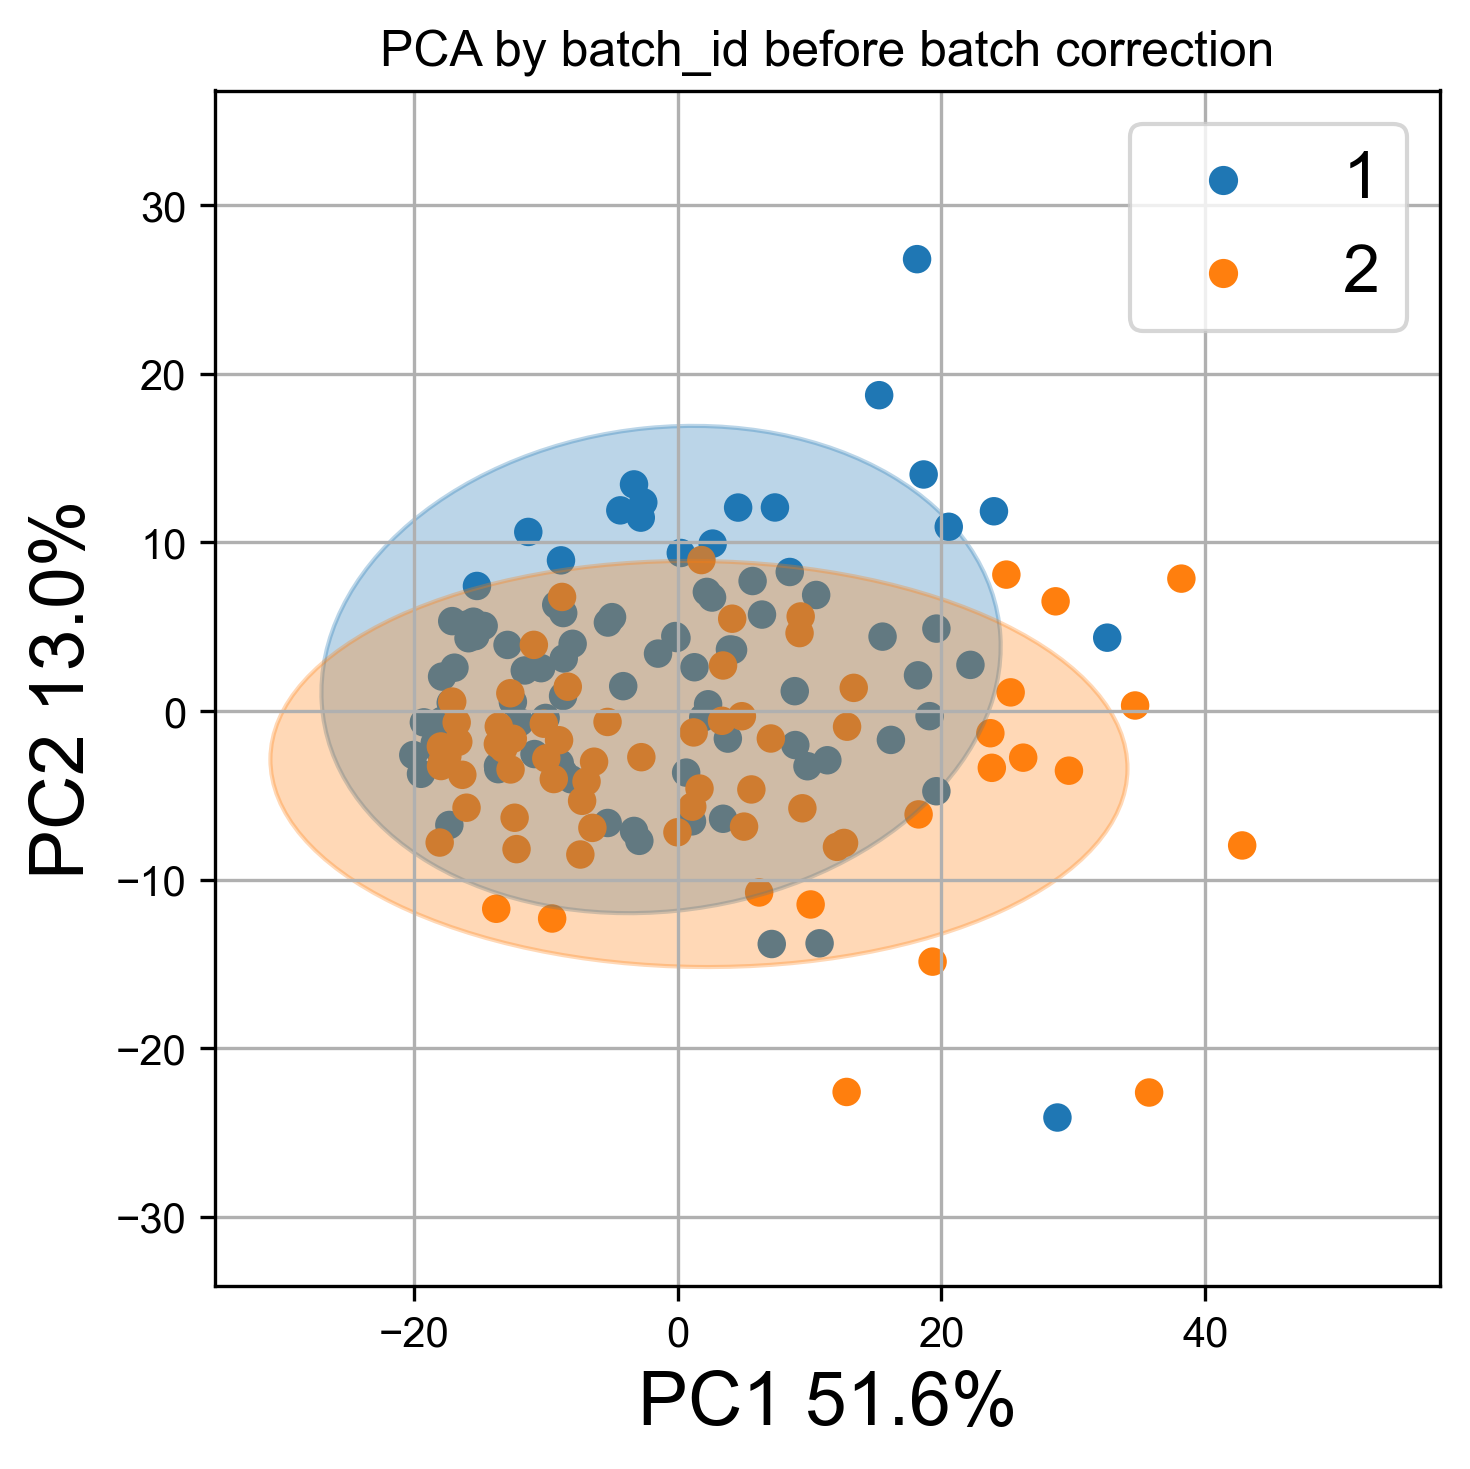

In [10]:
# pca by 'batch_id' before batch-correction
cols_X = df_log.columns[~df_log.columns.str.endswith('_id')]
data = df_log[cols_X].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'batch_id': df_log['batch_id'].values
})
plt.figure(figsize=(5, 5))
batch_colors = {df_plot['batch_id'].unique()[0]: '#1f77b4',
                df_plot['batch_id'].unique()[1]: '#ff7f0e'}
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='batch_id', data=df_plot, palette=batch_colors, s=40,
    edgecolor=None
)
# ellipse
for batch, color in batch_colors.items():
    batch_data = df_plot[df_plot['batch_id'] == batch]
    if len(batch_data) > 1:
        cov = np.cov(batch_data[['PC1', 'PC2']].T)
        mean = batch_data[['PC1', 'PC2']].mean().values
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% 置信区间
        ellipse = Ellipse(mean, width, height, angle, color=color,
                          alpha=0.3)
        ax.add_patch(ellipse)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(df_plot['PC1'].min() - 15, df_plot['PC1'].max() + 15)
ax.set_ylim(df_plot['PC2'].min() - 10, df_plot['PC2'].max() + 10)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.title('PCA by batch_id before batch correction')
plt.tight_layout()
plt.show()

In [11]:
# batch correction by limma
def remove_batch_limma(df):
    # names
    cols_X = df.columns[~df.columns.str.endswith('_id')]
    meta = df[['batch_id', 'treat_id']].copy()

    # R input
    ro.globalenv["data.sc.log"] = df[cols_X].values.T
    ro.globalenv["meta"] = meta

    # R script
    r_script = """
            suppressPackageStartupMessages({
                library(SingleCellExperiment)
                library(scran)
                library(limma)
            })
            expr_matrix <- data.sc.log
            batch <- meta$batch_id
            group <- meta$treat_id
            design <- model.matrix(~group)
            expr_corrected <- removeBatchEffect(
              expr_matrix,
              batch = batch,
              design = design
            )
            """
    ro.r(r_script)
    x = ro.r("expr_corrected")
    x = np.array(x)
    df[cols_X] = x.T
    return df
df_corr = remove_batch_limma(df_log)
df_corr.copy()

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y6C9,Q9Y696,Q9Y678,...,A8K2U0,A7E2Y1,A6NK97,A6NHR9,A4FU69,A4D1P6,A1L0T0,A1IGU5,A0FGR9,A0FGR8
0,DMSO,1,sample_4221,11.321793,11.851442,11.587457,11.925284,11.222361,11.171509,11.375932,...,11.294942,11.376610,11.197370,11.493553,11.574796,11.122797,11.168636,13.711717,10.929517,11.624104
1,DMSO,1,sample_4222,11.559417,12.119795,11.757649,12.621399,11.768398,11.180379,12.054356,...,11.616661,11.226094,11.186455,11.683347,11.730167,11.133777,11.105820,13.778853,10.923834,11.572023
2,DMSO,1,sample_4223,10.984823,11.840354,11.687625,12.403255,11.597181,11.328545,11.750884,...,11.659312,11.205383,11.236716,11.749786,11.491175,11.050981,11.222339,14.034063,11.070474,11.544939
3,DMSO,1,sample_4224,11.057921,11.813870,11.521007,12.063501,11.398603,11.161090,11.512563,...,11.550373,11.264989,11.273295,11.576647,11.543072,11.129270,11.257937,13.860984,11.061941,11.553312
4,DMSO,1,sample_4225,11.512502,11.678531,11.917284,12.519951,11.518877,11.175132,11.954639,...,11.925090,11.224491,11.195722,11.980867,11.562922,11.090799,11.233472,13.962673,11.063985,11.453797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,11.095726,11.730823,11.693838,12.245259,11.658013,11.366869,11.783424,...,11.231259,11.253389,11.205630,11.760124,11.316563,11.152535,11.236342,13.894087,10.953700,11.595870
153,LPS,2,sample_4468,11.010019,11.600507,11.790159,12.123380,11.569923,11.413969,11.752004,...,11.439442,11.305070,11.227635,11.614767,11.307327,11.194924,11.427481,14.000724,11.211274,11.450584
154,LPS,2,sample_4463,10.942795,11.682265,11.714630,12.294563,11.640899,11.438800,11.855916,...,11.287924,11.250628,11.204518,11.656855,11.295023,11.143615,11.297817,14.024399,10.958664,11.617479
155,LPS,2,sample_4464,11.249206,12.307878,11.978429,12.064301,11.560991,11.115298,11.719704,...,12.056175,11.635691,11.554383,11.592134,12.120788,11.516179,11.429151,13.571220,11.300828,12.087840


C:\Users\84118\AppData\Local\Temp\ipykernel_24468\2962818844.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,
C:\Users\84118\AppData\Local\Temp\ipykernel_24468\2962818844.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,


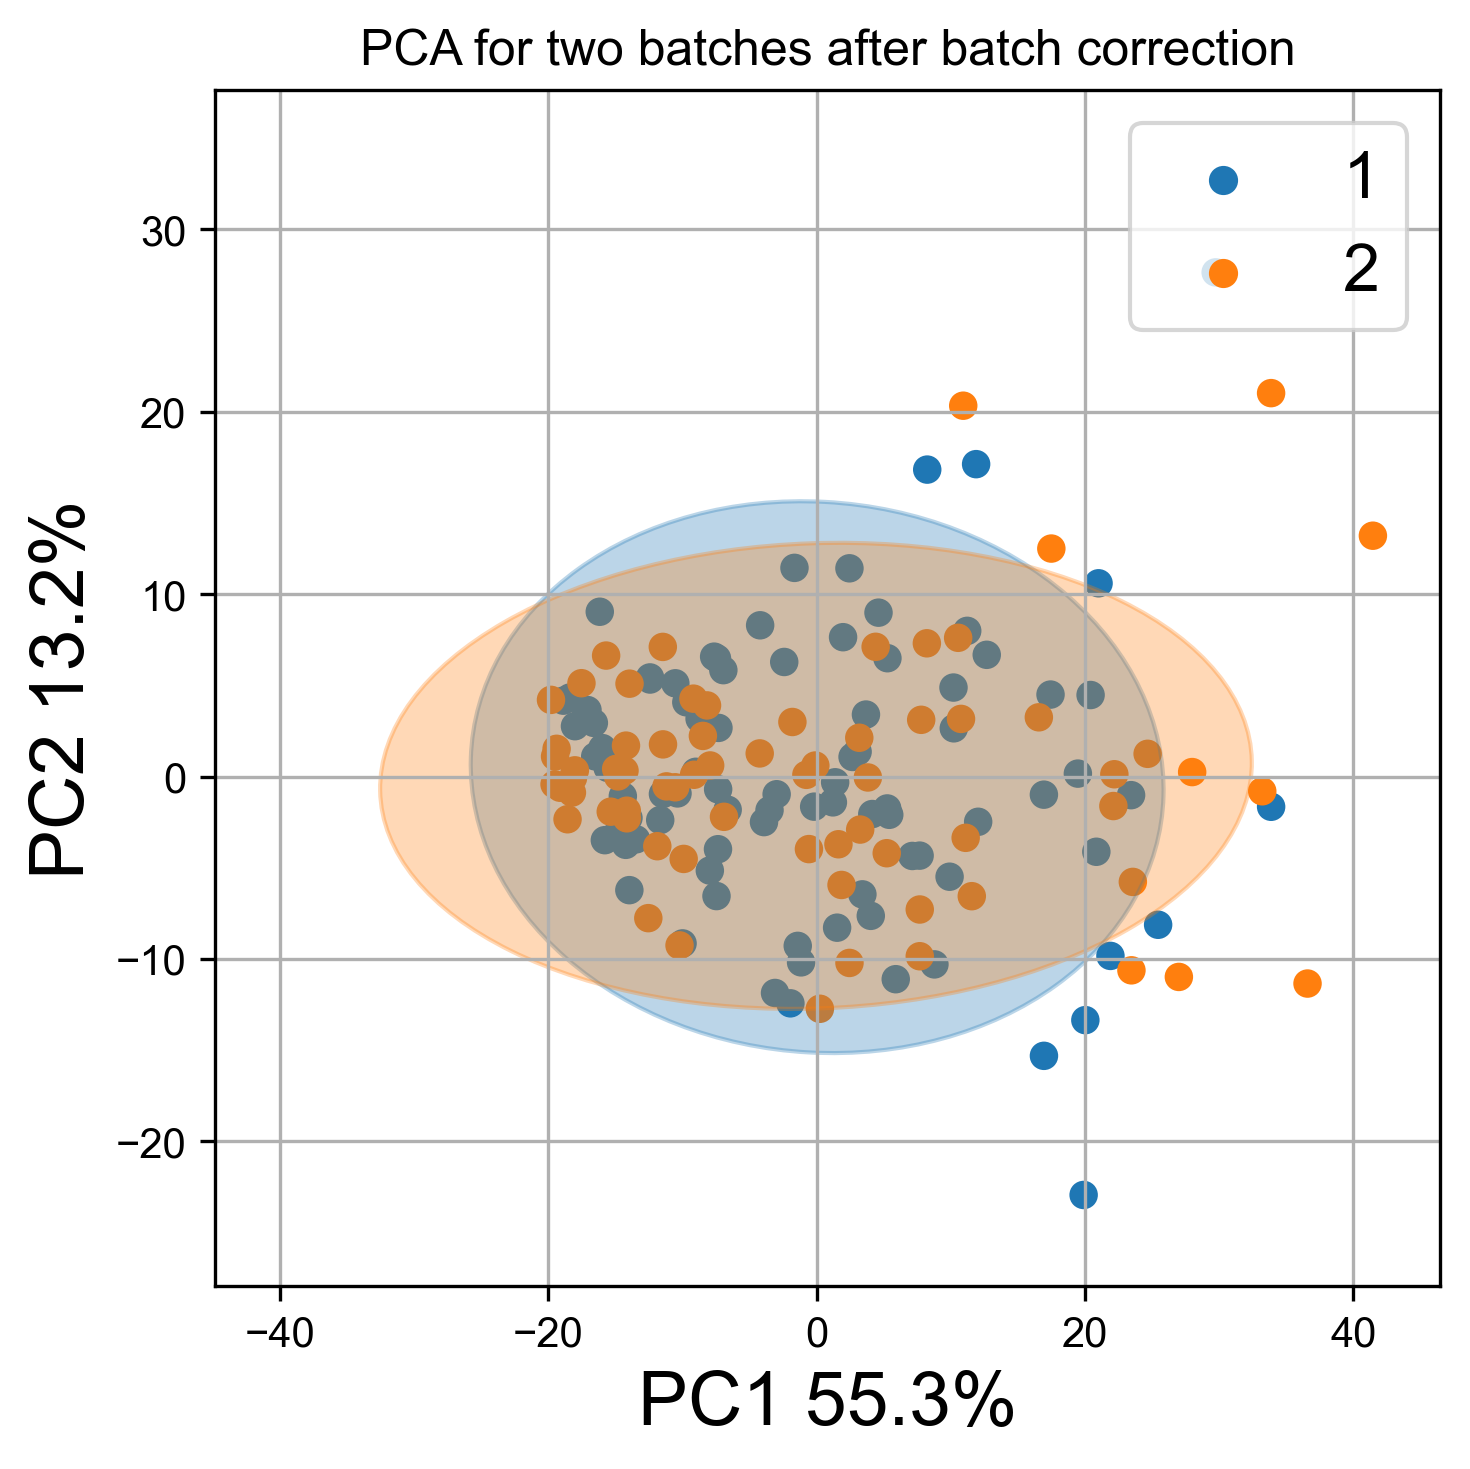

In [12]:
# pca by 'batch_id' after batch-correction
cols_X = df_corr.columns[~df_corr.columns.str.endswith('_id')]
data = df_corr[cols_X].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'batch_id': df_corr['batch_id'].values
})
plt.figure(figsize=(5, 5))
batch_colors = {df_plot['batch_id'].unique()[0]: '#1f77b4',
                df_plot['batch_id'].unique()[1]: '#ff7f0e'}
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='batch_id', data=df_plot, palette=batch_colors, s=40,
    edgecolor=None
)
# ellipse
for batch, color in batch_colors.items():
    batch_data = df_plot[df_plot['batch_id'] == batch]
    if len(batch_data) > 1:
        cov = np.cov(batch_data[['PC1', 'PC2']].T)
        mean = batch_data[['PC1', 'PC2']].mean().values
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% 置信区间
        ellipse = Ellipse(mean, width, height, angle, color=color,
                          alpha=0.3)
        ax.add_patch(ellipse)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(df_plot['PC1'].min() - 25, df_plot['PC1'].max() + 5)
ax.set_ylim(df_plot['PC2'].min() - 5, df_plot['PC2'].max() + 10)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.title('PCA for two batches after batch correction')
plt.tight_layout()
plt.show()

#### PCA

C:\Users\84118\AppData\Local\Temp\ipykernel_24468\2177862761.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,
C:\Users\84118\AppData\Local\Temp\ipykernel_24468\2177862761.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,


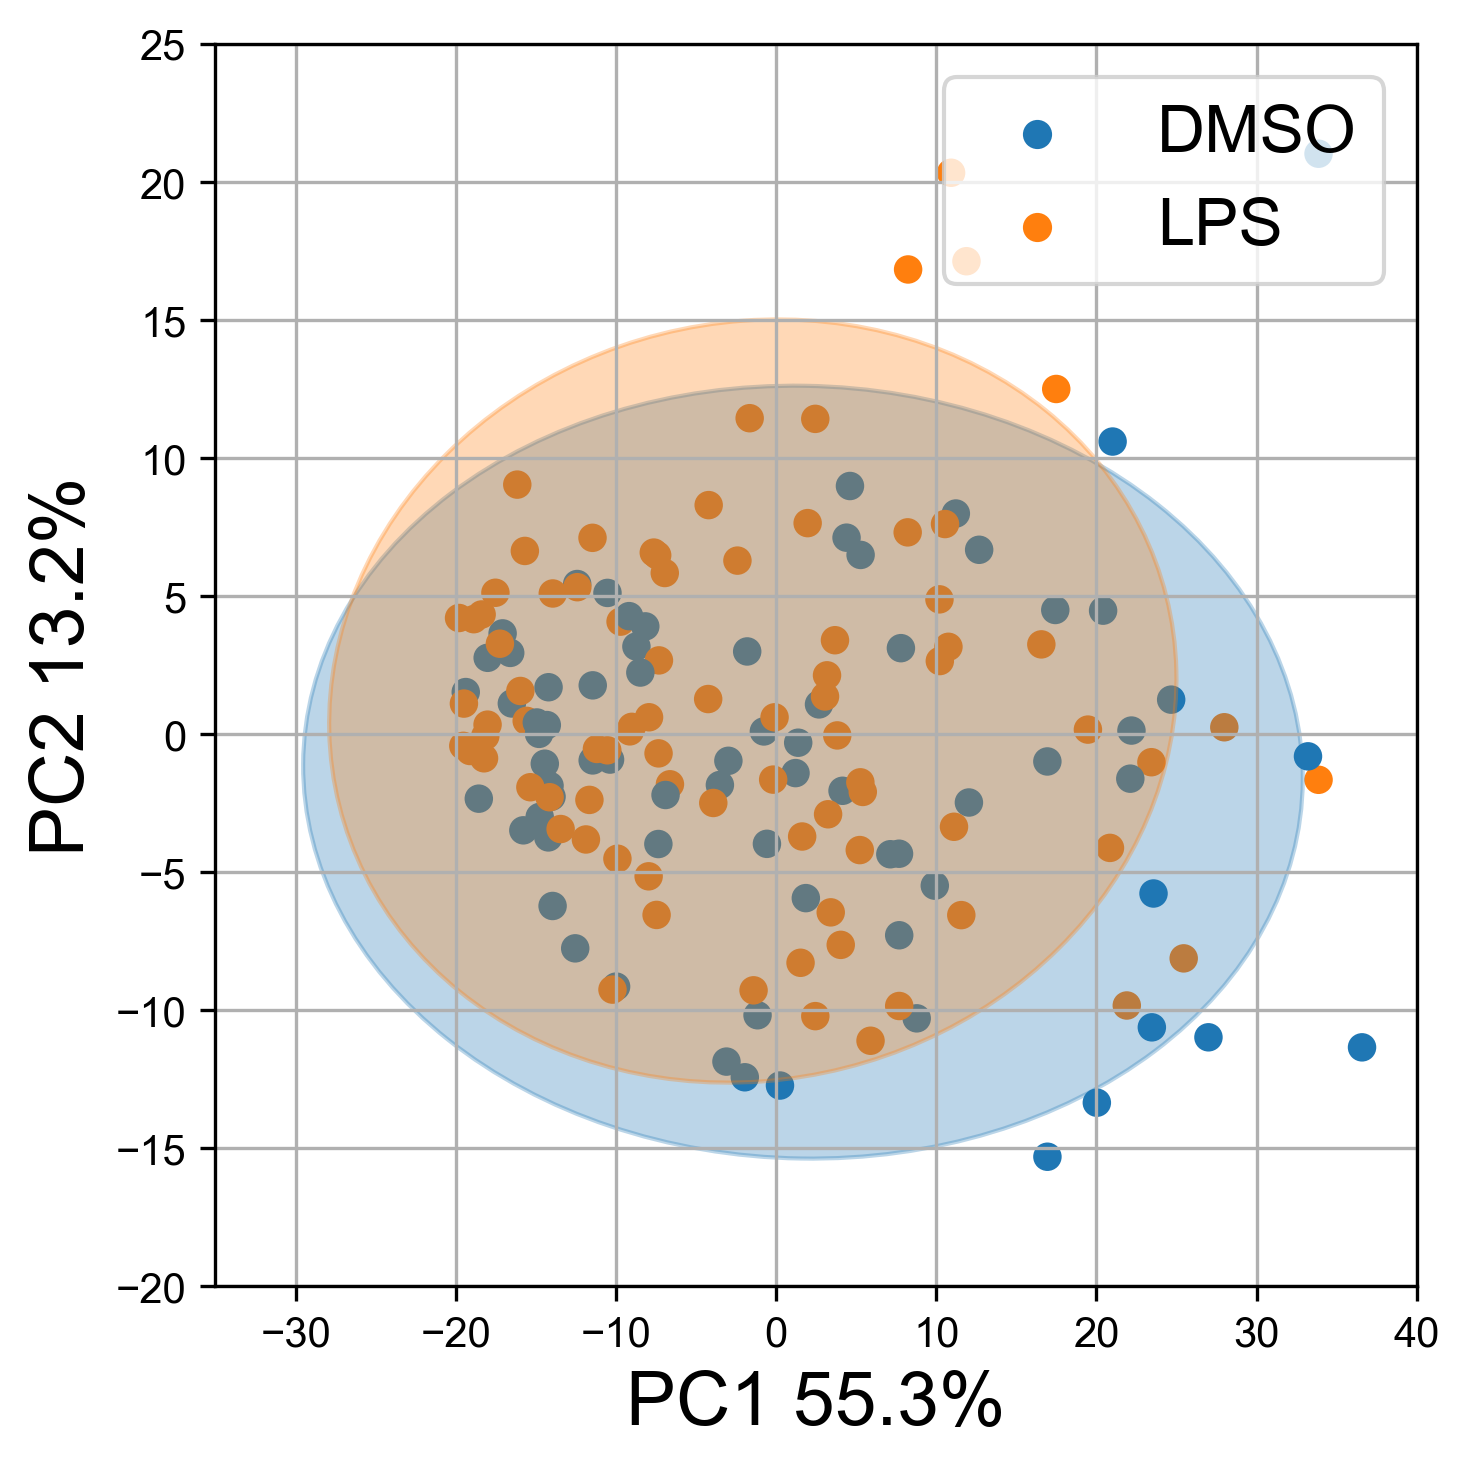

In [13]:
# pca by 'treat_id'
cols_X = df_corr.columns[~df_corr.columns.str.endswith('_id')]
data = df_corr[cols_X].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'treat_id': df_corr['treat_id'].values
})
plt.figure(figsize=(5, 5))
batch_colors = {df_plot['treat_id'].unique()[0]: '#1f77b4',
                df_plot['treat_id'].unique()[1]: '#ff7f0e'}
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='treat_id', data=df_plot, palette=batch_colors, s=40,
    edgecolor=None
)
# ellipse
for batch, color in batch_colors.items():
    batch_data = df_plot[df_plot['treat_id'] == batch]
    if len(batch_data) > 1:
        cov = np.cov(batch_data[['PC1', 'PC2']].T)
        mean = batch_data[['PC1', 'PC2']].mean().values
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% 置信区间
        ellipse = Ellipse(mean, width, height, angle, color=color,
                          alpha=0.3)
        ax.add_patch(ellipse)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(-35, 40)
ax.set_ylim(-20, 25)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.tight_layout()
plt.show()

#### Differential Expression
- LPS (treat group) vs. DMSO (control group)
- DEP calculation
- Volcano plot

In [14]:
# calculating: p, adj p, fc
def cal_fc_pvalue_limma(df):
    cols_X = df.columns[~df.columns.str.endswith('_id')]
    expr = df[cols_X].values.T
    meta = pd.DataFrame(
        {'Treatment': df['treat_id'].values})

    r_expr = ro.conversion.py2rpy(expr)
    r_meta = ro.conversion.py2rpy(meta)
    ro.globalenv['expr_matrix'] = r_expr
    ro.globalenv['meta'] = r_meta
    ro.globalenv['protein'] = ro.StrVector(cols_X.to_list())

    r_script = '''
            library(limma)
            rownames(expr_matrix) <- protein
            design <- model.matrix(~ Treatment, data = meta)
            fit <- lmFit(expr_matrix, design)
            fit <- eBayes(fit)
            diff_results <- topTable(fit, coef="TreatmentLPS", number=Inf, adjust.method="BH")
            '''
    ro.r(r_script)
    df = ro.r('diff_results')
    df = pd.DataFrame(df).reset_index(names='protein')
    return df
df_dep = cal_fc_pvalue_limma(df_corr)
df_dep.copy()

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,P27695,-0.405398,14.078666,-6.004771,1.271213e-08,0.000016,9.389563
1,P09429,-0.437449,15.305213,-5.945728,1.707916e-08,0.000016,9.115480
2,P26639,-0.354487,13.353554,-5.623534,8.298058e-08,0.000048,7.649826
3,P26583,-0.275454,13.796233,-5.577107,1.037495e-07,0.000048,7.442951
4,Q9P0S9,-0.171632,12.743021,-4.953508,1.858269e-06,0.000690,4.777704
...,...,...,...,...,...,...,...
1851,P61619,0.000296,11.115395,0.007467,9.940516e-01,0.996117,-6.156924
1852,P48739,-0.000174,11.349128,-0.006895,9.945071e-01,0.996117,-6.156928
1853,P17096,0.000250,12.238254,0.005939,9.952688e-01,0.996342,-6.156934
1854,Q07065,0.000170,11.765636,0.003163,9.974805e-01,0.998018,-6.156946


In [15]:
# assign up and down
cut_fc, cut_p = 0., 0.05
df_dep['state'] = 'none'
idx_up = (df_dep['logFC'] > cut_fc) & (df_dep['adj.P.Val'] < cut_p)
idx_down = (df_dep['logFC'] < -cut_fc) & (df_dep['adj.P.Val'] < cut_p)
df_dep.loc[idx_up, 'state'] = 'up'
df_dep.loc[idx_down, 'state'] = 'down'
n_neg = sum(df_dep['logFC'] < 0)
n_pos = sum(df_dep['logFC'] > 0)
n_down = sum(df_dep['state'] == 'down')
n_up = sum(df_dep['state'] == 'up')
print(f'left area: {n_down}/{n_neg}, right area: {n_up}/{n_pos}')
df_dep.copy()

left area: 31/718, right area: 59/1138


,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,state
0,P27695,-0.405398,14.078666,-6.004771,1.271213e-08,0.000016,9.389563,down
1,P09429,-0.437449,15.305213,-5.945728,1.707916e-08,0.000016,9.115480,down
2,P26639,-0.354487,13.353554,-5.623534,8.298058e-08,0.000048,7.649826,down
3,P26583,-0.275454,13.796233,-5.577107,1.037495e-07,0.000048,7.442951,down
4,Q9P0S9,-0.171632,12.743021,-4.953508,1.858269e-06,0.000690,4.777704,down
...,...,...,...,...,...,...,...,...
1851,P61619,0.000296,11.115395,0.007467,9.940516e-01,0.996117,-6.156924,none
1852,P48739,-0.000174,11.349128,-0.006895,9.945071e-01,0.996117,-6.156928,none
1853,P17096,0.000250,12.238254,0.005939,9.952688e-01,0.996342,-6.156934,none
1854,Q07065,0.000170,11.765636,0.003163,9.974805e-01,0.998018,-6.156946,none


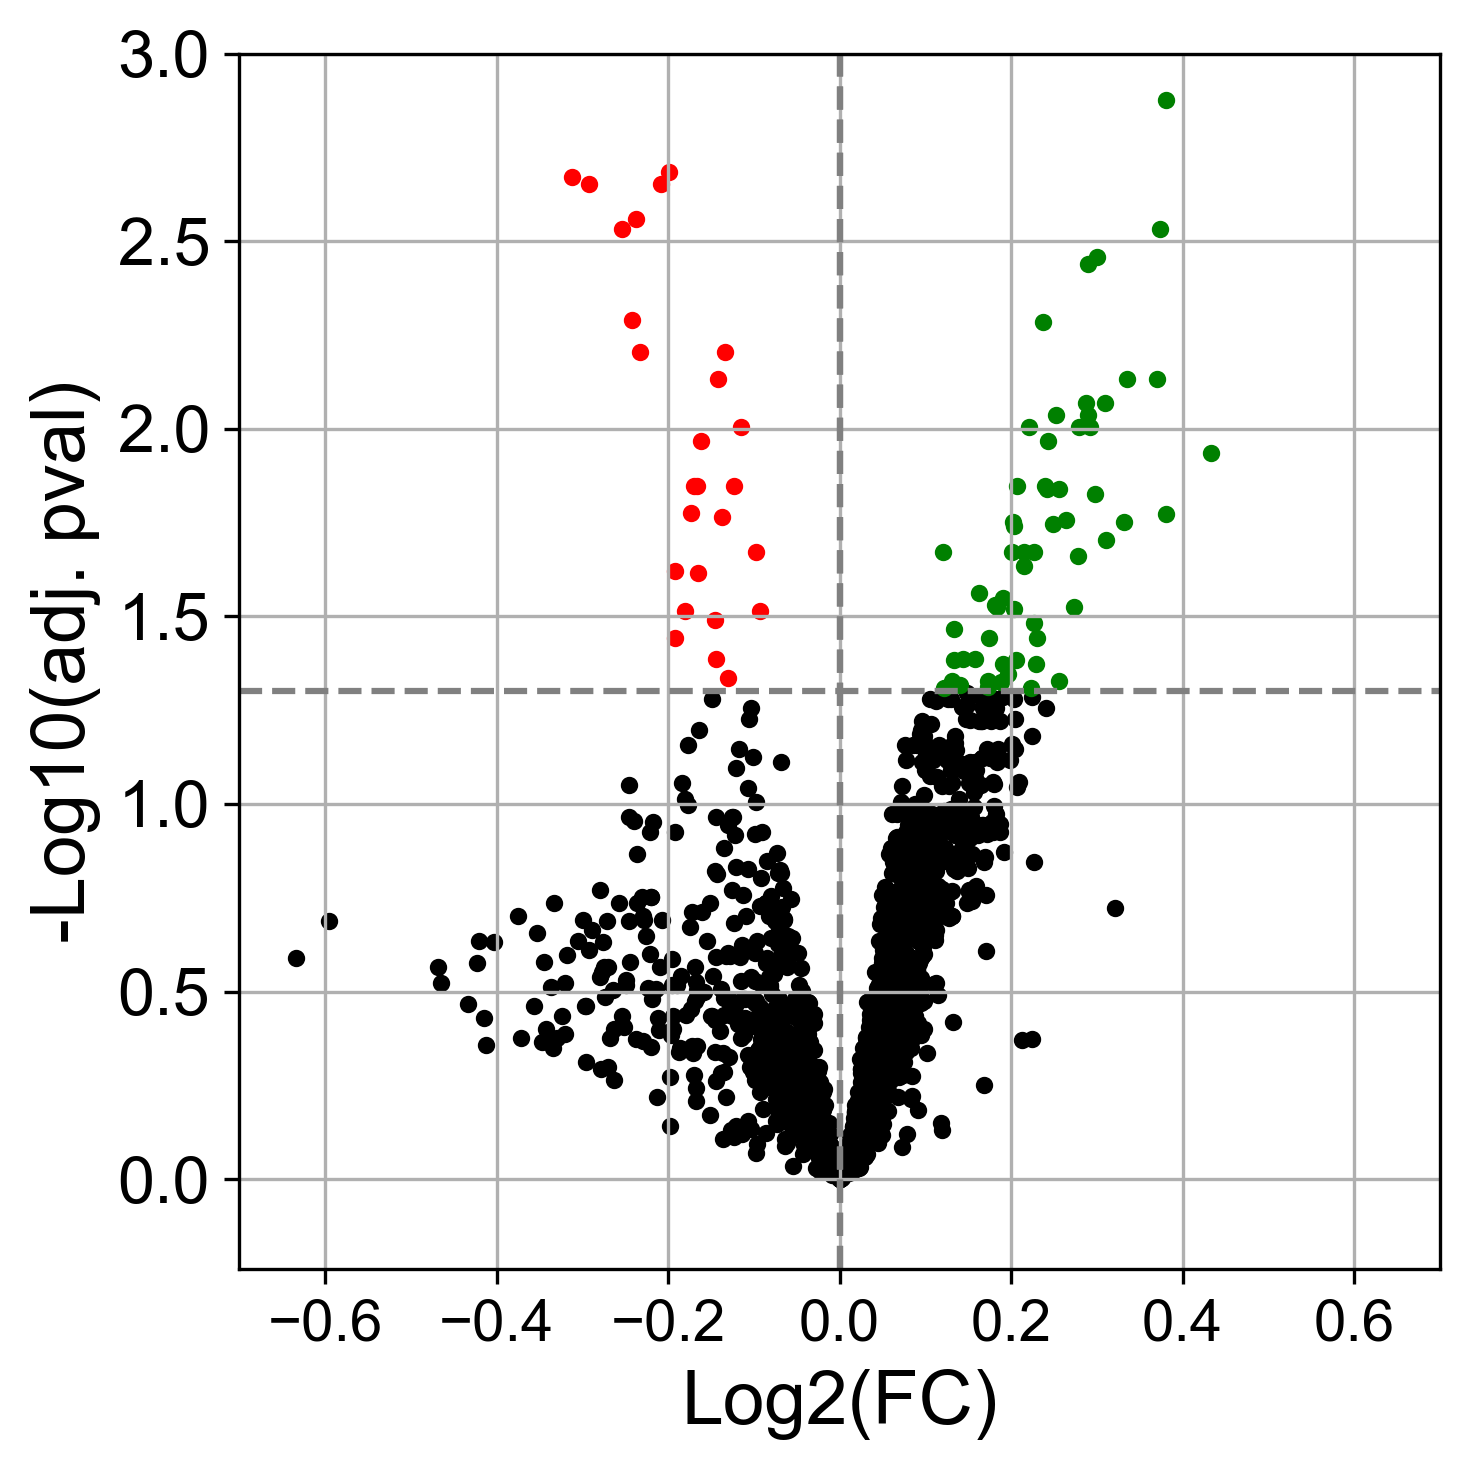

In [16]:
# valcano plot
df_dep['Y'] = -np.log10(df_dep['adj.P.Val'])
df_none = df_dep[df_dep['state'] == 'none']
df_up = df_dep[df_dep['state'] == 'up']
df_down = df_dep[df_dep['state'] == 'down']

plt.figure(figsize=(5, 5))
plt.scatter(x=df_none['logFC'],
            y=df_none['Y'],
            s=10, label="Not significant", color='black')
plt.scatter(x=df_down['logFC'],
            y=df_down['Y'],
            s=10, color="red")
plt.scatter(x=df_up['logFC'],
            y=df_up['Y'],
            s=10, color="green")

plt.axvline(cut_fc, color="grey", linestyle="--")
plt.axvline(-cut_fc, color="grey", linestyle="--")
plt.axhline(-np.log10(cut_p), color="grey", linestyle="--")

plt.ylabel("-Log10(adj. pval)", fontsize=18)
plt.xlabel("Log2(FC)", fontsize=18)
plt.xticks(fontweight='light', fontsize=14)
plt.yticks(fontweight='light', fontsize=16)
plt.grid(True)
plt.ylim(None, 3.)
plt.xlim(-0.7, 0.7)
# plt.xticks(np.arange(-1, 1.2, 0.5))
plt.tight_layout()
plt.show()

#### Pathway Analysis

In [17]:
# pg --> gene
protein_ids, gene_names, is_isoforms = [], [], []
with open(report_dir/'meta'/'swissprot_UP5640_human_20420_20240619.fasta', 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith(">"):
            protein_id = line.split('|')[1]
            gene_name = None
            for field in line.split():
                if field.startswith("GN="):
                    gene_name = field.split("=")[1]
                    break
            protein_ids.append(protein_id)
            gene_names.append(gene_name)
            is_isoforms.append(line.__contains__('isoform'))
df_map = pd.DataFrame({
    "protein": protein_ids, "gene": gene_names
})
df_map = df_map.dropna().reset_index(drop=True)
df_gene = pd.merge(df_dep, df_map, on='protein')
df_gene.copy()

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,state,Y,gene
0,P27695,-0.405398,14.078666,-6.004771,1.271213e-08,0.000016,9.389563,down,4.799986,APEX1
1,P09429,-0.437449,15.305213,-5.945728,1.707916e-08,0.000016,9.115480,down,4.799986,HMGB1
2,P26639,-0.354487,13.353554,-5.623534,8.298058e-08,0.000048,7.649826,down,4.317496,TARS1
3,P26583,-0.275454,13.796233,-5.577107,1.037495e-07,0.000048,7.442951,down,4.317496,HMGB2
4,Q9P0S9,-0.171632,12.743021,-4.953508,1.858269e-06,0.000690,4.777704,down,3.161283,TMEM14C
...,...,...,...,...,...,...,...,...,...,...
1851,P61619,0.000296,11.115395,0.007467,9.940516e-01,0.996117,-6.156924,none,0.001690,SEC61A1
1852,P48739,-0.000174,11.349128,-0.006895,9.945071e-01,0.996117,-6.156928,none,0.001690,PITPNB
1853,P17096,0.000250,12.238254,0.005939,9.952688e-01,0.996342,-6.156934,none,0.001591,HMGA1
1854,Q07065,0.000170,11.765636,0.003163,9.974805e-01,0.998018,-6.156946,none,0.000862,CKAP4


TRAF6 Mediated IRF7 Activation In TLR7/8 Or 9 Signaling;IRAK1 Recruits IKK Complex;STAT5 Activation Downstream Of FLT3 ITD Mutants;Constitutive Signaling By Overexpressed ERBB2;RHOBTB GTPase Cycle;RHOBTB2 GTPase Cycle;L13a-mediated Translational Silencing Of Ceruloplasmin Expression;GTP Hydrolysis And Joining Of 60S Ribosomal Subunit;Constitutive Signaling By EGFRvIII;Cap-dependent Translation Initiation;GRB2:SOS Provides Linkage To MAPK Signaling For Integrins;Signaling By FLT3 ITD And TKD Mutants;Signaling By ERBB2 ECD Mutants;Response Of EIF2AK4 (GCN2) To Amino Acid Deficiency;Constitutive Signaling By Ligand-Responsive EGFR Cancer Variants


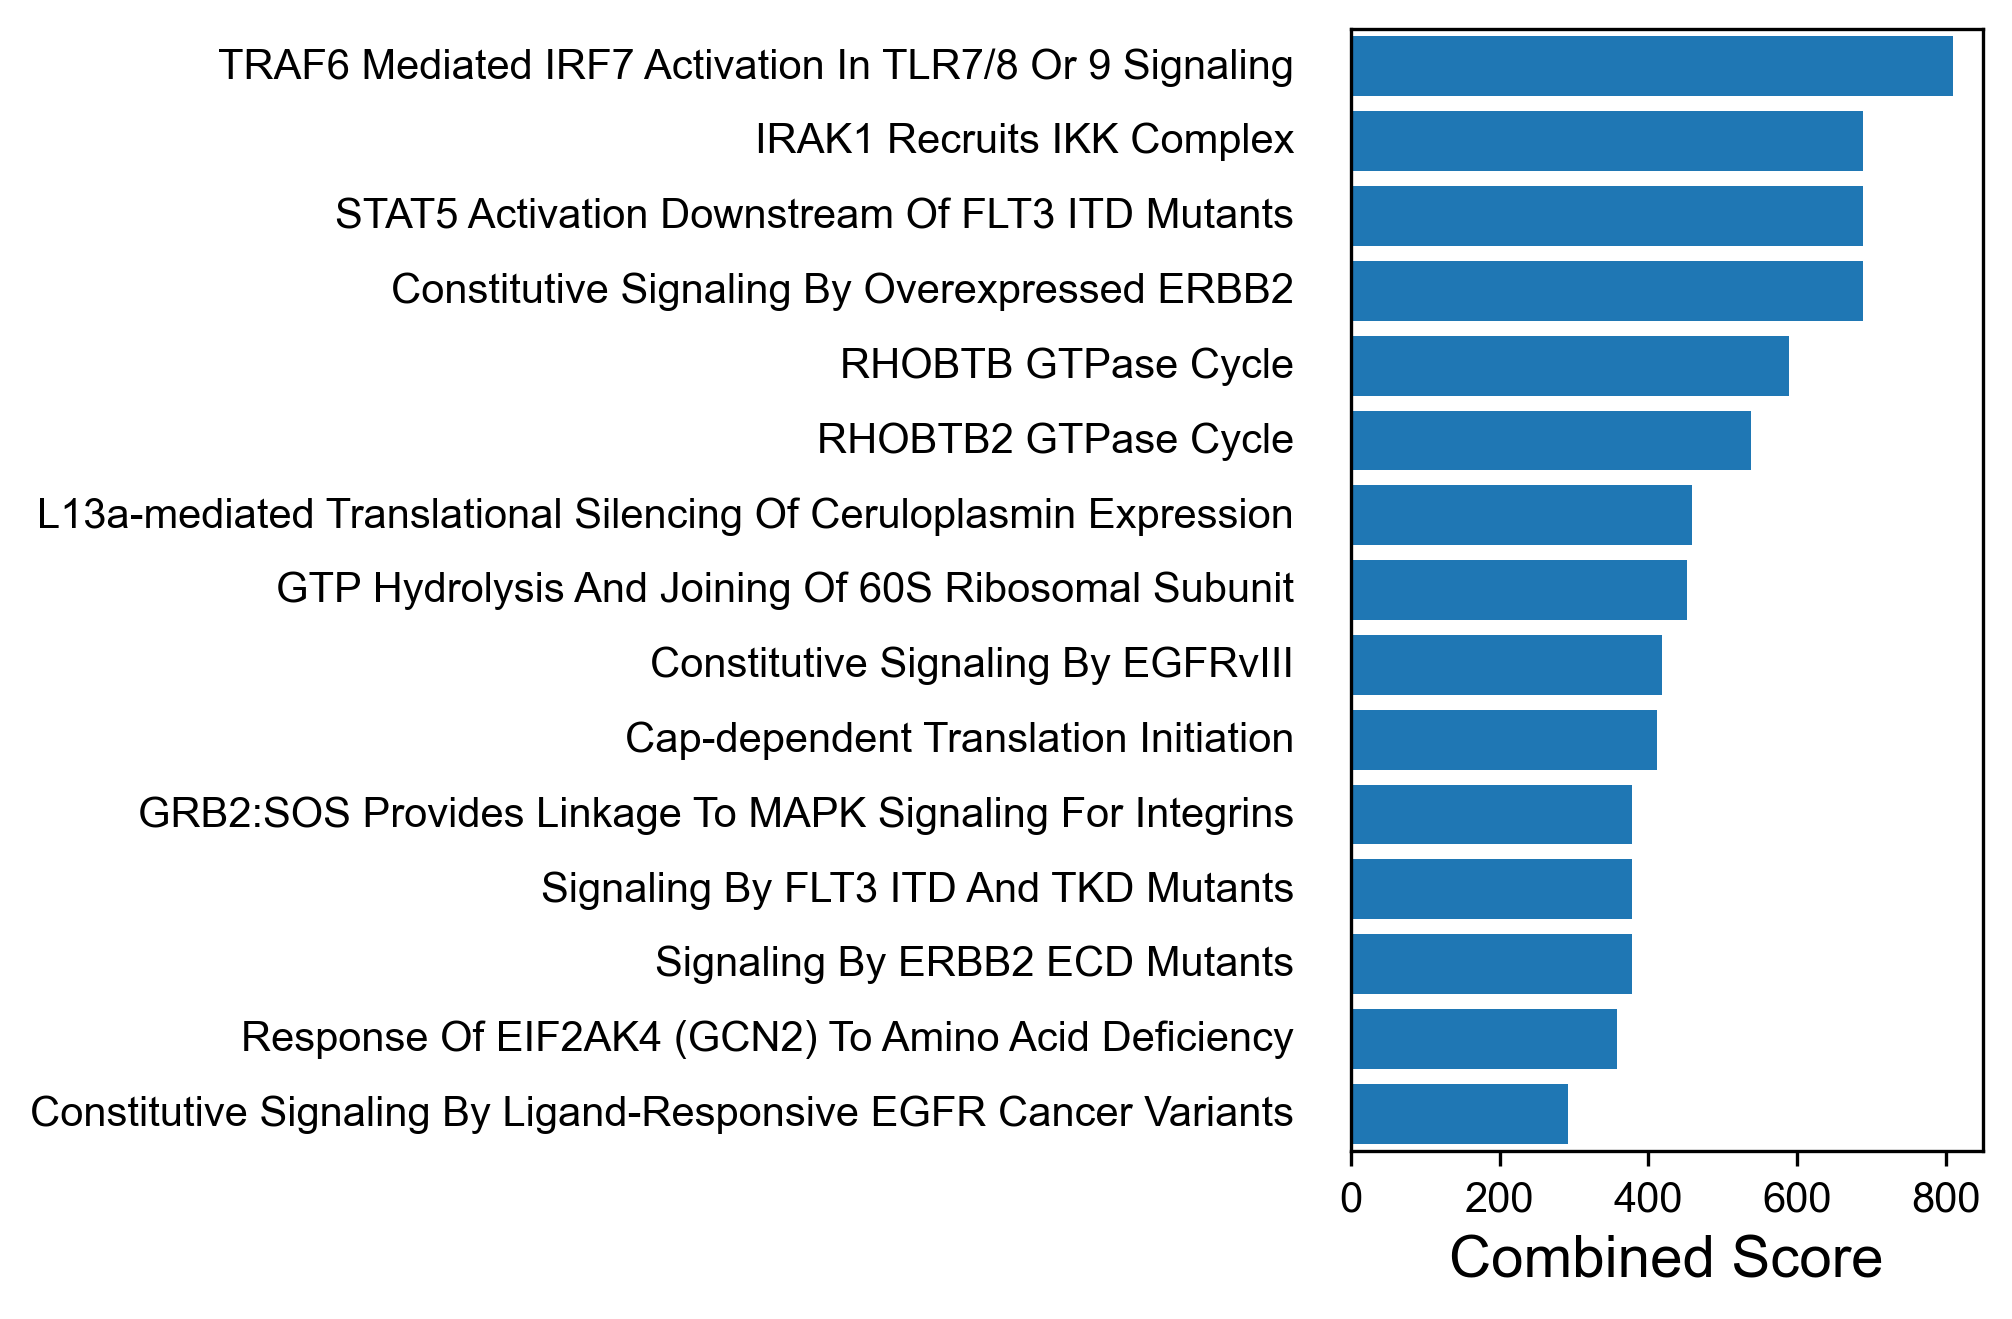

In [18]:
# up pathway enrichment plot
import gseapy as gp
import matplotlib.gridspec as gridspec

n_path = 15

ups = set(df_gene[df_gene['state'] == 'up']['gene'])
enr = gp.enrichr(gene_list=list(ups),
                 gene_sets='Reactome_2022',
                 organism='Human',
                 outdir=None)
df_path = enr.results
df_path = df_path[df_path['Adjusted P-value'] < cut_p]
df_path = df_path.nlargest(n_path, 'Combined Score')

df_path['Term'] = df_path['Term'].str.split(' R-HSA-').str[0]
df_path = df_path.sort_values('Combined Score', ascending=True)
print(df_path['Term'][::-1].str.cat(sep=';'))

terms = df_path['Term'].astype(str).tolist()
scores = df_path['Combined Score'].tolist()
y_pos = np.arange(len(terms))

fig = plt.figure(figsize=(7.5, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# Left for terms
ax_text = plt.subplot(gs[0])
ax_text.set_xlim(0, 1)
ax_text.set_ylim(-0.5, len(terms) - 0.5)
ax_text.axis('off')
for i, term in enumerate(terms):
    ax_text.text(1.0, i, term, va='center', ha='right', fontsize=10)

# Right for scores
ax_bar = plt.subplot(gs[1])
ax_bar.barh(y_pos, scores)
ax_bar.set_yticks([])
ax_bar.set_ylim(-0.5, len(terms) - 0.5)
ax_bar.set_xlabel('Combined Score', fontsize=14)

plt.tight_layout()
plt.show()